In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.afw.detection as afwDet
import lsst.afw.image as afwImage
from lsst.afw.image import ImageI, PARENT
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils
import proxmin

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

from lsst.daf.persistence import Butler

WORK_DIR = os.path.join("/tigress", "fredem", "lsst", "test_data")
butler = Butler(inputs=os.path.join(WORK_DIR, "rerun/example2"))

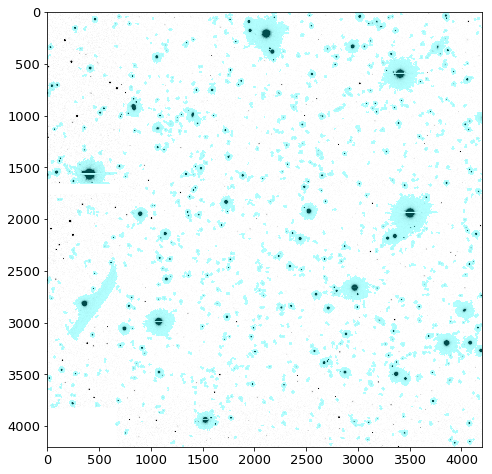

In [25]:
#visits = butler.queryMetadata('deepCoadd', ['visit'], dataId={'filter':'HSC-I'})
calexp = {}
for f in ["I", "R"]:
    calexp[f] = butler.get('deepCoadd_calexp', patch="1,1", filter="HSC-"+f, tract=0)
img = calexp["I"].getMaskedImage().getImage().getArray()
catalog = butler.get("deepCoadd_mergeDet", patch="1,1", tract=0)
tbl = catalog.asAstropy()

footprints = ImageI(calexp["I"].getBBox())
for n,src in enumerate(catalog):
    fp = src.getFootprint()
    peaks = fp.getPeaks()
    if len(peaks)>1:
        fp.getSpans().setImage(footprints, 1)
plt.figure(figsize=(8,8))
plt.imshow(img, vmax=10, cmap="Greys", vmin=0)
fpimg = np.ma.array(footprints.getArray())
fpimg.mask = fpimg==0
plt.imshow(fpimg, cmap="cool", alpha=.3)

In [26]:
from lsst.meas.deblender import MultibandDeblendTask

config = MultibandDeblendTask.ConfigClass()
#config.catchFailures = True
config.edgeHandling = 'noclip'
config.clipFootprintToNonzero = False
config.conserveFlux = True
config.maxIter = 100
config.processSingles = True

schema = catalog.schema
schemaMapper = afwTable.SchemaMapper(schema)
schemaMapper.addMinimalSchema(schema)
schema = schemaMapper.getOutputSchema()
peakSchema = butler.get("deepCoadd_peak_schema", intermediate=True).schema
deblendTask = MultibandDeblendTask(schema=schema, peakSchema=peakSchema, config=config)
table = afwTable.SourceTable.make(schema)
sources = afwTable.SourceCatalog(table)
sources.extend(catalog, schemaMapper)

result = deblendTask.run(calexp, sources[10:20])

INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations
INFO:proxmin.algorithms:Completed 101 iterations


In [27]:
#sources, templates, catalogs, debResult = result
catalogs, templates = result

In [28]:
len(templates["I"]), len(catalogs["I"])

(31, 31)

In [29]:
templates["I"].asAstropy().show_in_notebook()

idx,id,coord_ra,coord_dec,parent,merge_footprint_i2,merge_footprint_i,merge_footprint_r2,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_N921,merge_footprint_N816,merge_footprint_N1010,merge_footprint_N387,merge_footprint_N515,merge_footprint_sky,merge_peak_i2,merge_peak_i,merge_peak_r2,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_N921,merge_peak_N816,merge_peak_N1010,merge_peak_N387,merge_peak_N515,merge_peak_sky,runtime,deblend_nChild,deblend_deblendedAsPsf,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_failed,deblend_skipped,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux
,,rad,rad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,,,,
0,141733920779,nan,nan,0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,1135.52,6,False,True,False,False,False,False,nan,nan,nan,False,False,False
1,3492,nan,nan,141733920779,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False
2,3493,nan,nan,141733920779,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False
3,3494,nan,nan,141733920779,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False
4,141733920780,nan,nan,0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,2629.75,10,False,True,False,False,False,False,nan,nan,nan,False,False,False
5,3496,nan,nan,141733920780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False
6,3497,nan,nan,141733920780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False
7,3498,nan,nan,141733920780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False
8,3499,nan,nan,141733920780,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,0,False,False,False,False,False,False,nan,nan,nan,False,False,False


In [32]:
def showPeaks(calexp, catalog, idx, vmin=None, vmax=None, mask=False, show_image=True, title="", cutoff=0):
    from lsst.afw.image import PARENT
    src = catalog[idx]
    image = afwImage.ImageF(src.getFootprint().getBBox())
    xmin = image.getBBox().getMinX()
    ymin = image.getBBox().getMinY()
    peaks = []
    if src.get("parent") == 0:
        pid = src.getId()
        _peaks = catalog[catalog.get("parent")==pid]
        for peak in _peaks:
            timg = afwImage.ImageF(src.getFootprint().getBBox())
            heavy = peak.getFootprint()
            heavy.insert(timg)
            image += timg
            peaks.append([heavy.getPeaks()[0].getFx()-xmin, heavy.getPeaks()[0].getFy()-ymin])
    else:
        heavy = src.getFootprint()
        heavy.insert(image)
    if len(peaks)==0:
        return
    
    _img = calexp.image
    _img = _img.Factory(_img, image.getBBox(), PARENT).array
    if vmax is not None:
        vmax = min(2, np.max(_img))
    if show_image:
        plt.imshow(_img, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Data")
        plt.show()
    
    img = image.array
    if mask:
        img = np.ma.array(img, mask=img<=cutoff)
    plt.imshow(img, vmin=vmin, vmax=vmax)
    for pk in peaks:
        plt.plot(pk[0],pk[1], 'cx', mew=2)
    plt.colorbar()
    plt.title(title)
    plt.show()

INFO:lsst.meas.deblender:Index:0


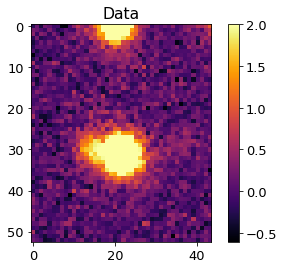

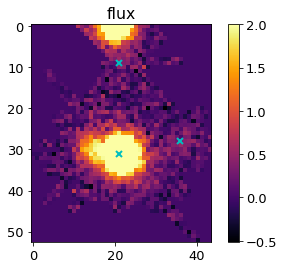

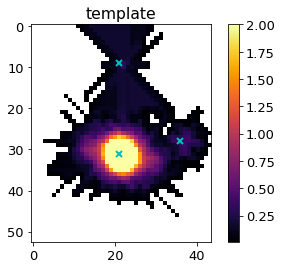

INFO:lsst.meas.deblender:Index:1
INFO:lsst.meas.deblender:Index:2
INFO:lsst.meas.deblender:Index:3
INFO:lsst.meas.deblender:Index:4


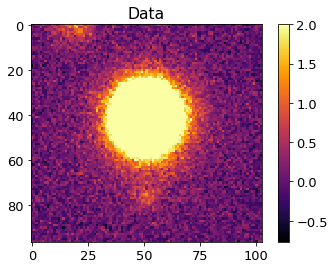

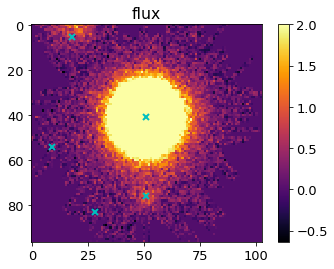

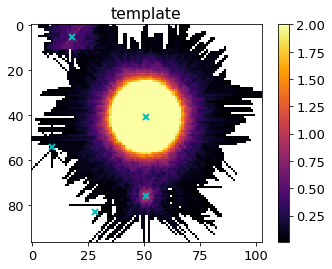

INFO:lsst.meas.deblender:Index:5
INFO:lsst.meas.deblender:Index:6
INFO:lsst.meas.deblender:Index:7
INFO:lsst.meas.deblender:Index:8
INFO:lsst.meas.deblender:Index:9
INFO:lsst.meas.deblender:Index:10


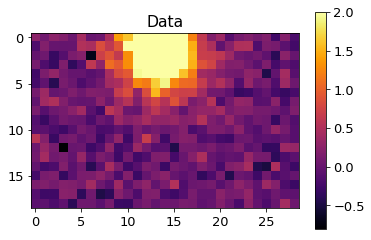

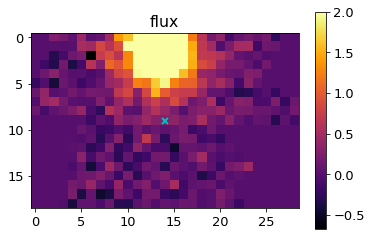

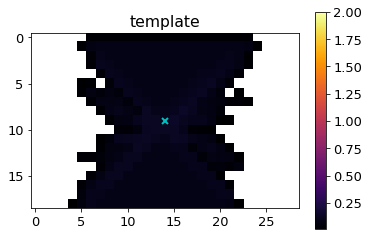

INFO:lsst.meas.deblender:Index:11
INFO:lsst.meas.deblender:Index:12


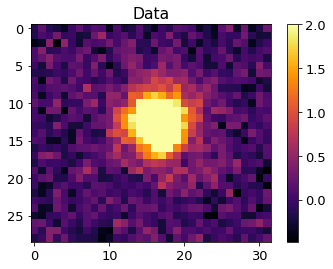

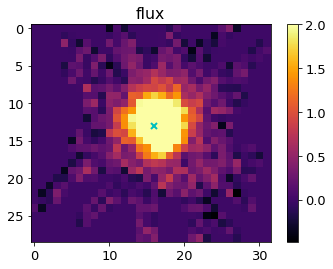

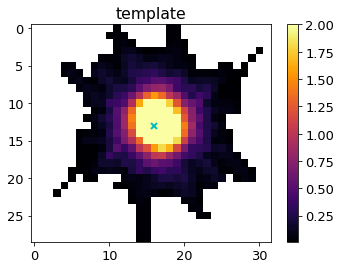

INFO:lsst.meas.deblender:Index:13
INFO:lsst.meas.deblender:Index:14


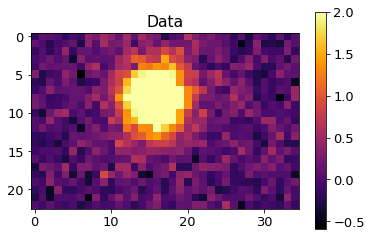

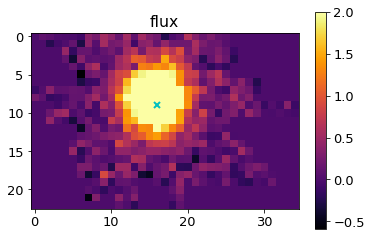

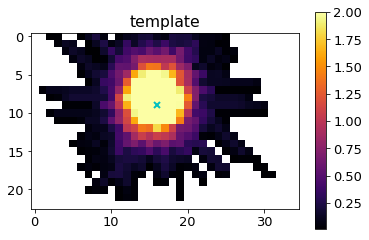

INFO:lsst.meas.deblender:Index:15
INFO:lsst.meas.deblender:Index:16


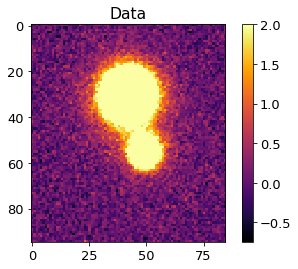

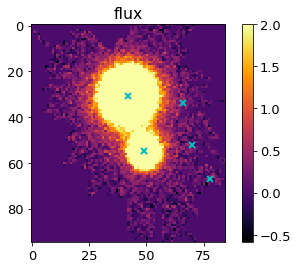

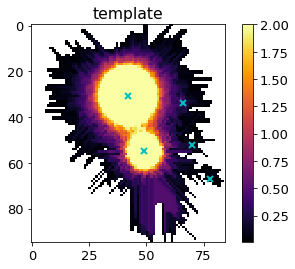

INFO:lsst.meas.deblender:Index:17
INFO:lsst.meas.deblender:Index:18
INFO:lsst.meas.deblender:Index:19
INFO:lsst.meas.deblender:Index:20
INFO:lsst.meas.deblender:Index:21
INFO:lsst.meas.deblender:Index:22


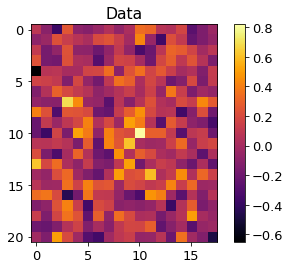

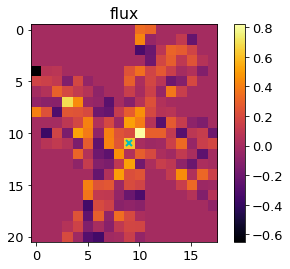

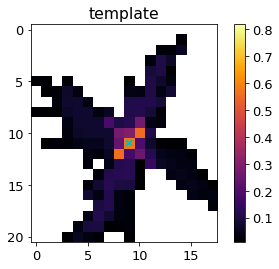

INFO:lsst.meas.deblender:Index:23
INFO:lsst.meas.deblender:Index:24


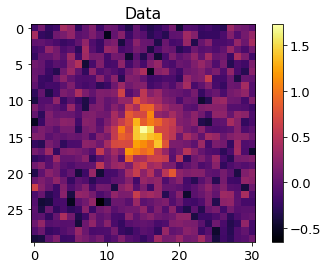

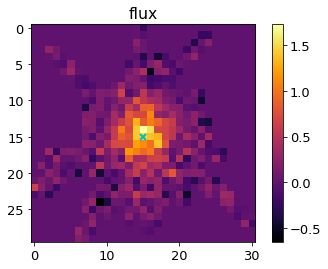

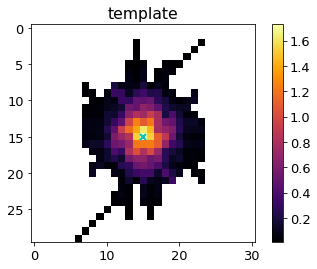

INFO:lsst.meas.deblender:Index:25
INFO:lsst.meas.deblender:Index:26


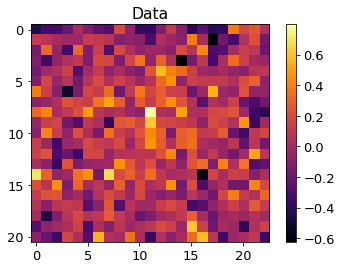

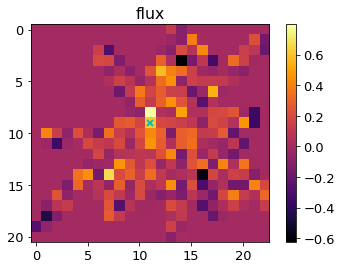

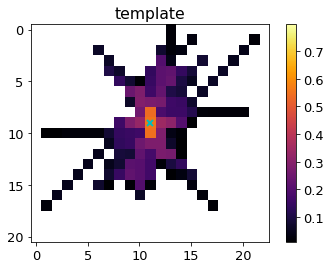

INFO:lsst.meas.deblender:Index:27
INFO:lsst.meas.deblender:Index:28


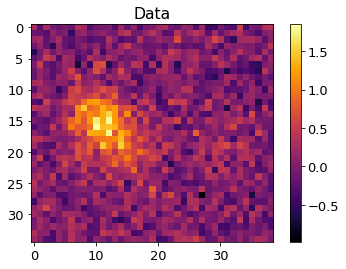

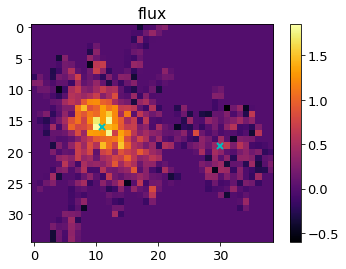

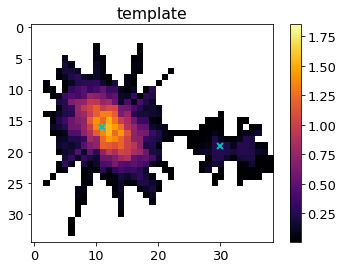

INFO:lsst.meas.deblender:Index:29
INFO:lsst.meas.deblender:Index:30


In [33]:
for idx in range(len(catalogs["I"])):
    logger.info("Index:{0}".format(idx))
    if catalogs["I"][idx].get("parent") == 0:
        showPeaks(calexp["I"], catalogs["I"], idx, vmax=2, title="flux")
        showPeaks(calexp["I"], templates["I"], idx, vmax=2, mask=True, title="template", show_image=False, cutoff=.01)

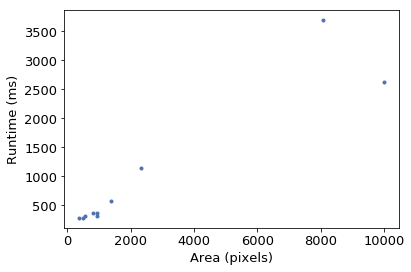

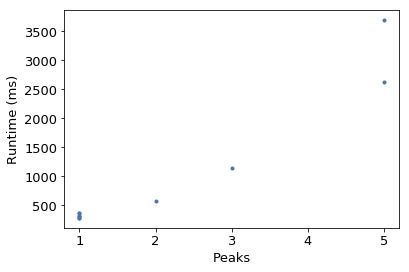

In [34]:
cuts = (catalogs["I"].get("parent")==0)&(catalogs["I"].get("runtime")>0)
areas = np.array([src.getFootprint().getBBox().getArea() for src in catalogs["I"][cuts]])
peaks = np.array([len(src.getFootprint().getPeaks()) for src in catalogs["I"][cuts]])
runtime = catalogs["I"].get("runtime")[cuts]
plt.plot(areas, runtime, '.')
plt.xlabel("Area (pixels)")
plt.ylabel("Runtime (ms)")
plt.show()
plt.plot(peaks, runtime, '.')
plt.xlabel("Peaks")
plt.ylabel("Runtime (ms)")